In [ ]:
!git clone https://github.com/Etienne-bdt/BEI-SIA25
!unzip /content/BEI-SIA25/data.zip /content/BEI-SIA25/data

In [1]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm

from utils.dataloader import CadastreSen2Dataset
from utils.index_calculation import BSI, NDBI, NDMI, NDVI, NDWI

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the data

Get the data

Prepare pytorch dataset

In [3]:
dataset = CadastreSen2Dataset(image_path="./data/")

No numpy patches found in ./data/31035\patches
No numpy patches found in ./data/57591\patches


Prepare dataloader

In [4]:
batch_size = 16
num_threads = 0

#Split into train and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_threads)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_threads)

# Model definition

In [5]:
class Conv2DRegressionModel(nn.Module): # prédiction de l'image 2024
    def __init__(self, int_channels: int = 11):
        super(Conv2DRegressionModel, self).__init__()
        self.nb_channel = int_channels
        self.encoder = nn.Sequential(
            nn.Conv2d(int_channels, 16, kernel_size=3, padding="same"),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding="same"),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding="same"),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 10, kernel_size=4),
            nn.BatchNorm2d(10),
            nn.ReLU(),
        )

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        y = self.encoder(X)
        y = self.decoder(y)
        return y
    

# Train the model

In [ ]:
import ignite.metrics as im

In [ ]:
n_epochs = 10
learning_rate = 0.001

model = Conv2DRegressionModel()
model = model.to(device)


# metric = im.SSIM(data_range=1.0)
# metric.attach(im.default_evaluator, 'ssim')
# preds = torch.rand([4, 3, 16, 16])
# target = preds * 0.75
# state = im.default_evaluator.run([[preds, target]])
# print(state.metrics['ssim'])

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_set_len = len(train_loader)
val_set_len = len(val_loader)

train_loss_comp, val_loss_comp = [], []
train_loss_pred, val_loss_pred = [], []
train_loss_comp_pred, val_loss_comp_pred = [], []
train_loss_tot, val_loss_tot = [], []
best_loss=1000000
for epoch in tqdm(range(n_epochs)):
    model.train()
    accu_comp = 0.0
    accu_pred = 0.0
    accu_comp_pred = 0.0
    accu_total = 0.0

    for x, y, mask in train_loader:
        x,y,mask = x.to(device), y.to(device), mask.to(device)
        x,y,mask = x.float(), y.float(), mask.float()
        optimizer.zero_grad()
        # img_2018, img_2024 = img_2018.to(device), img_2024.to(device)
        # Forward pass
        in_x = torch.cat((x, mask), dim=1)
        y_pred = model(in_x) # image 2024 prédite à partir de 2018
        Ind_comp = NDVI(y_pred)
        Ind_comp = torch.cat((Ind_comp, NDWI(y_pred)), dim=1)
        Ind_comp = torch.cat((Ind_comp, NDBI(y_pred)), dim=1)
        Ind_comp = torch.cat((Ind_comp, NDMI(y_pred)), dim=1)
        Ind_comp = torch.cat((Ind_comp, BSI(y_pred)), dim=1)
        Ind_real = y[:,5:,:,:]
        Ind_pred = y_pred[:,5:,:,:]
        weights = torch.tensor([0.4, 0.2, 0.2, 0.1, 0.1], device=device) # pondération à ajuster
        loss_comp = sum(w * loss_fn(comp, true) for w, comp, true in zip(weights, Ind_comp, Ind_real)) # comparaison des indices calculés
        loss_pred = sum(w * loss_fn(pred, true) for w, pred, true in zip(weights, Ind_pred, Ind_real)) # comparaison des indices prédits
        loss_comp_pred = sum(w * loss_fn(comp, pred) for w, comp, pred in zip(weights, Ind_comp, Ind_pred)) # comparaison des indices calculés et prédits
        total_loss = loss_comp + loss_pred + loss_comp_pred

        accu_comp += loss_comp.item()
        accu_pred += loss_pred.item()
        accu_comp_pred += loss_comp_pred.item()
        accu_total += total_loss.item()
        # Backward pass
        total_loss.backward()
        optimizer.step()

    train_loss_comp.append(accu_comp / train_set_len)
    train_loss_pred.append(accu_pred / train_set_len)
    train_loss_comp_pred.append(accu_comp_pred / train_set_len)
    train_loss_tot.append(accu_total / train_set_len)
    # Validation - no gradient & eval mode
    model.eval()
    accu_comp = 0.0
    accu_pred = 0.0
    accu_comp_pred = 0.0
    accu_total = 0.0

    with torch.no_grad():
        for x, y, mask in val_loader:
            x,y,mask = x.to(device), y.to(device), mask.to(device)
            x,y,mask = x.float(), y.float(), mask.float()
            in_x = torch.cat((x, mask), dim=1)
            y_pred = model(in_x)
            Ind_comp = NDVI(y_pred)
            Ind_comp = torch.cat((Ind_comp, NDWI(y_pred)), dim=1)
            Ind_comp = torch.cat((Ind_comp, NDBI(y_pred)), dim=1)
            Ind_comp = torch.cat((Ind_comp, NDMI(y_pred)), dim=1)
            Ind_comp = torch.cat((Ind_comp, BSI(y_pred)), dim=1)
            Ind_real = y[:,5:,:,:]
            Ind_pred = y_pred[:,5:,:,:]
            weights = torch.tensor([0.4, 0.2, 0.2, 0.1, 0.1], device=device)
            loss_comp = sum(w * loss_fn(comp, true) for w, comp, true in zip(weights, Ind_comp, Ind_real))
            loss_pred = sum(w * loss_fn(pred, true) for w, pred, true in zip(weights, Ind_pred, Ind_real))
            loss_comp_pred = sum(w * loss_fn(comp, pred) for w, comp, pred in zip(weights, Ind_comp, Ind_pred))
            total_loss = loss_comp + loss_pred + loss_comp_pred

            accu_comp += loss_comp.item()
            accu_pred += loss_pred.item()
            accu_comp_pred += loss_comp_pred.item()
            accu_total += total_loss.item()

    val_loss_comp.append(accu_comp / val_set_len)
    val_loss_pred.append(accu_pred / val_set_len)
    val_loss_comp_pred.append(accu_comp_pred / val_set_len)
    val_loss_tot.append(accu_total / val_set_len)

    if accu_total < best_loss:
        best_loss = accu_total
        torch.save(model.state_dict(), "best_model.pt")

    if epoch % 1 == 0:
        print(f"Epoch {epoch + 1}/{n_epochs} - Train loss: {train_loss_tot[-1]:.4f} - Val loss: {val_loss_tot[-1]:.4f}")

    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"model_{epoch}.pt")
    

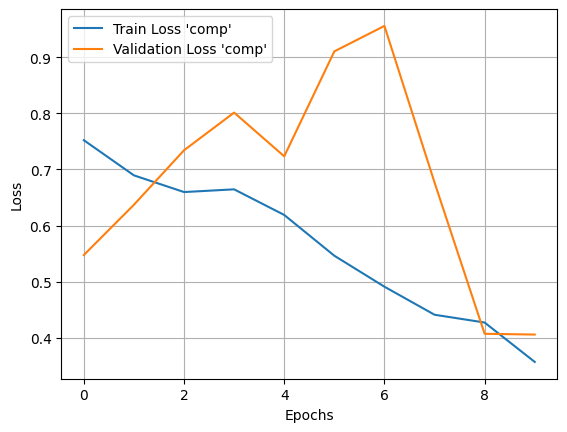

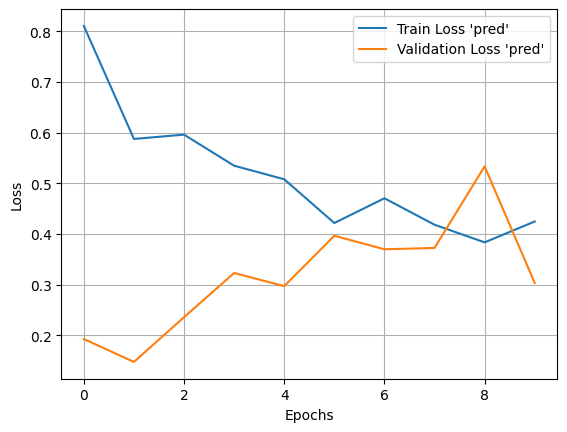

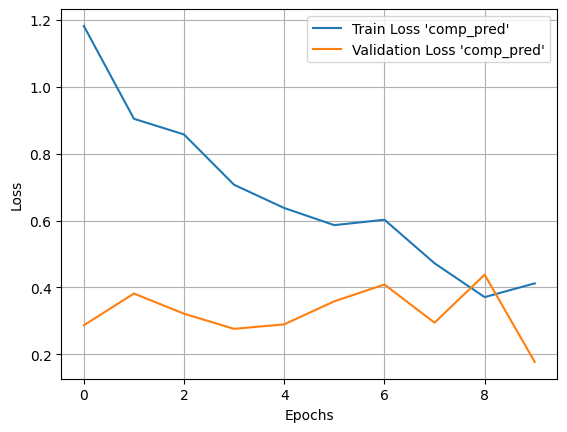

In [7]:
plt.plot(train_loss_comp, label="Train Loss 'comp'")
plt.plot(val_loss_comp, label="Validation Loss 'comp'")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

plt.plot(train_loss_pred, label="Train Loss 'pred'")
plt.plot(val_loss_pred, label="Validation Loss 'pred'")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

plt.plot(train_loss_comp_pred, label="Train Loss 'comp_pred'")
plt.plot(val_loss_comp_pred, label="Validation Loss 'comp_pred'")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..7.764047].


Text(0.5, 1.0, 'Après')

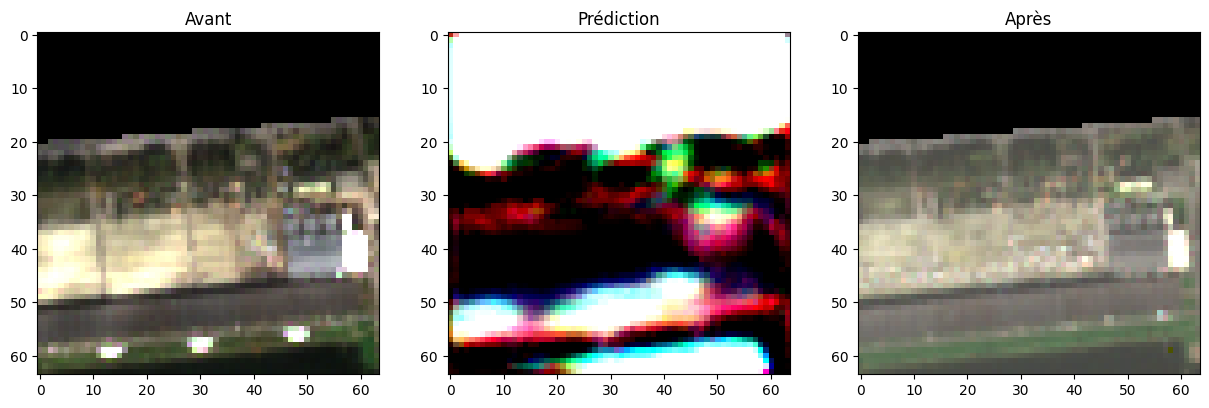

In [9]:
model.cpu()

x,y,mask = next(iter(val_loader))
in_x = torch.cat((x, mask), dim=1)
y_pred = model(in_x.float())

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(x[0, 0:3, :, :].permute(1, 2, 0))
axs[0].set_title("Avant")
axs[1].imshow(y_pred[0, 0:3, :, :].detach().permute(1, 2, 0))
axs[1].set_title("Prédiction")
axs[2].imshow(y[0, 0:3, :, :].permute(1, 2, 0))
axs[2].set_title("Après")